<a href="https://colab.research.google.com/github/LokeshVadlamudi/MachineLearningClass/blob/master/FinalML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*Title Vs Body Factor*

importing Libs

In [0]:
import numpy as np
import pandas as pd

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

importing Liar Liar DataSet


In [0]:
link = ' https://drive.google.com/open?id=1rBLusojbUoNYeAEsNnDaXhrpT3oQxIfh'
fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('liar.zip')

#extracting the bigger liar zip file to get both train and test .tsv files
import zipfile
with zipfile.ZipFile('liar.zip', 'r') as zip_ref:
    zip_ref.extractall()

trainLiar = pd.read_csv('train.tsv', sep='\t',header=None)
trainLiar = trainLiar.drop(columns=[0])

columns=['label','statement','subject','speaker','speaker_job_title','state info','party affiliation',
'barely_true_counts','false_counts','half_true_counts','mostly_true_counts',
'pants_on_fire_counts','context']

trainLiar.columns=columns

testLiar = pd.read_csv('test.tsv', sep='\t',header=None)
testLiar = testLiar.drop(columns=[0])


columns=['label','statement','subject','speaker','speaker_job_title','state info','party affiliation',
'barely_true_counts','false_counts','half_true_counts','mostly_true_counts',
'pants_on_fire_counts','context']

testLiar.columns=columns

checking head of both the sets

In [5]:
trainLiar.head()

,label,statement,subject,speaker,speaker_job_title,state info,party affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [6]:
testLiar.head()

,label,statement,subject,speaker,speaker_job_title,state info,party affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


lets combine our dataframe into one big dataframe

In [0]:
liar=pd.concat([trainLiar,testLiar])

#just generating synonyms for our title which is subject here. because it has only few words

lets us clean both our title and body first

In [8]:
import nltk
nltk.download('wordnet')
import string
def remove_punctuations(data):
    d = "".join([i for i in str(data) if i not in string.punctuation])
    return d
from nltk.tokenize import RegexpTokenizer
def tokenize(data):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(data.lower())

from nltk.corpus import stopwords
nltk.download('stopwords')
def remove_stopwords(data):
    data = [i for i in data if i not in stopwords.words('english')]
    return data
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

def lematize(data):
    data = [lemma.lemmatize(i) for i in data]
    return data

from nltk.stem.porter import PorterStemmer
stemming = PorterStemmer()
def stem(data):
    data = " ".join([stemming.stem(i) for i in data])
    return data

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


applying the cleaning functions to our body

In [0]:
liar['finalStatement'] = liar.apply(lambda row: remove_punctuations(row['statement']), axis=1)

liar['finalStatement'] = liar.apply(lambda row: tokenize(row['finalStatement']), axis=1)

liar['finalStatement'] = liar.apply(lambda row: remove_stopwords(row['finalStatement']), axis=1)

liar['finalStatement'] = liar.apply(lambda row: lematize(row['finalStatement']), axis=1)

liar['finalStatement'] = liar.apply(lambda row: stem(row['finalStatement']), axis=1)

In [10]:
liar.head()

,label,statement,subject,speaker,speaker_job_title,state info,party affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,finalStatement
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support thirdtrimest...
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,declin coal start start natur ga took start be...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillari clinton agre john mccain vote give geo...
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legisl like mandat free sex...
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term


we need to break our subject and clean it too

In [0]:
import re
def break_subject(text):
  if type(text) is float:
    return []
  import re
  return re.split('; |, |-',text)

In [0]:
liar['finalSubject'] = liar.apply(lambda row: break_subject(row['subject']), axis=1)

In [13]:
liar.head()

,label,statement,subject,speaker,speaker_job_title,state info,party affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,finalStatement,finalSubject
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support thirdtrimest...,[abortion]
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,declin coal start start natur ga took start be...,"[energy,history,job, accomplishments]"
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillari clinton agre john mccain vote give geo...,"[foreign, policy]"
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legisl like mandat free sex...,"[health, care]"
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term,"[economy,jobs]"


generate similar words

In [0]:
from nltk.corpus import wordnet 
def generate_Synonyms(wordlist):
    synonyms = set()
    for i in wordlist:
      if type(i) is not str:
        continue
      for syn in wordnet.synsets(i): 
          for l in syn.lemmas(): 
              synonyms.add(l.name())
    return list(synonyms)

In [0]:
liar['subjectSynonyms'] = liar.apply(lambda row: generate_Synonyms(row['finalSubject']), axis=1)

combining the list of subject words into one sentence

In [0]:
def combineSynonyms(data):
    return ' '.join(data)

In [0]:
liar['subjectSynonyms'] = liar['subjectSynonyms'].apply(lambda x: combineSynonyms(x))

In [18]:
liar.head()

,label,statement,subject,speaker,speaker_job_title,state info,party affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,finalStatement,finalSubject,subjectSynonyms
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support thirdtrimest...,[abortion],miscarriage abortion
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,declin coal start start natur ga took start be...,"[energy,history,job, accomplishments]",acquisition attainment acquirement achievement...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillari clinton agre john mccain vote give geo...,"[foreign, policy]",foreign extraneous policy insurance_policy ins...
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legisl like mandat free sex...,"[health, care]",handle upkeep aid fear maintenance forethought...
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term,"[economy,jobs]",


lets apply doc2vectorizor and cosine similarity for both title and body

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# applying tfidf Vectorizor and cosine similarity and creating a similarity feature

In [0]:
# create the transform
def cosine_sim(statement):
    statement=statement.split('@@')
    # print(statement)
    text1,text2=statement[0],statement[1]
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf = vectorizer.fit_transform([text1, text2])
    sim_score=((tfidf * tfidf.T).A)[0,1]
    # if sim_score*100>0:
    #   return 1
    return sim_score

In [0]:
liar['test_string'] = liar['finalStatement'] +'@@'+liar['subjectSynonyms']

In [0]:
liar['cosineSim']=liar['test_string'].apply(lambda x: cosine_sim(x))

In [25]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11725470606956321132, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3753376435442547560
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15068664414202778495
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8068188330160091477
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [26]:
liar.head()

,label,statement,subject,speaker,speaker_job_title,state info,party affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,finalStatement,finalSubject,subjectSynonyms,test_string,cosineSim
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support thirdtrimest...,[abortion],miscarriage abortion,say anni list polit group support thirdtrimest...,0.000000
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,declin coal start start natur ga took start be...,"[energy,history,job, accomplishments]",acquisition attainment acquirement achievement...,declin coal start start natur ga took start be...,0.000000
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillari clinton agre john mccain vote give geo...,"[foreign, policy]",foreign extraneous policy insurance_policy ins...,hillari clinton agre john mccain vote give geo...,0.000000
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legisl like mandat free sex...,"[health, care]",handle upkeep aid fear maintenance forethought...,health care reform legisl like mandat free sex...,0.112172
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term,"[economy,jobs]",,econom turnaround start end term@@,0.000000


lets label encode the labels

In [0]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
label.fit(liar['label'].astype(str))
liar['label'] = label.fit_transform(liar['label'].astype(str))

# Liar Data processed

In [29]:
liar.head()

,label,statement,subject,speaker,speaker_job_title,state info,party affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,finalStatement,finalSubject,subjectSynonyms,test_string,cosineSim
0,1,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support thirdtrimest...,[abortion],miscarriage abortion,say anni list polit group support thirdtrimest...,0.000000
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,declin coal start start natur ga took start be...,"[energy,history,job, accomplishments]",acquisition attainment acquirement achievement...,declin coal start start natur ga took start be...,0.000000
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillari clinton agre john mccain vote give geo...,"[foreign, policy]",foreign extraneous policy insurance_policy ins...,hillari clinton agre john mccain vote give geo...,0.000000
3,1,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legisl like mandat free sex...,"[health, care]",handle upkeep aid fear maintenance forethought...,health care reform legisl like mandat free sex...,0.112172
4,2,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term,"[economy,jobs]",,econom turnaround start end term@@,0.000000


The above liar df is the proper cleaned data

In [0]:
liar_clean1 = liar[['cosineSim','label']]

function to run all the algorithms on the data

In [0]:
from sklearn.metrics import plot_confusion_matrix
def fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test):
    accuracy={}
    specificity={}
    sensitivity={}
    model_save=None
    i=0
    #models_dict holds name and its function , like {'LR':LogsticRegression()}
    for name,model in models_dict.items():
        #fitting model on the train data
        model.fit(X_train,y_train)
        joblib.dump(model, name+'.pkl')
        #predicting model on X_test 
        model_save=model
        y_pred=model.predict(X_test)
        print('*'*100)
        print('Model:',name)
        #printing Confusion matrix an dAccuracy of each model
        print("Confusion Matrix: ")
        print(confusion_matrix(y_test, y_pred))
        print("Accuracy : ",accuracy_score(y_test,y_pred)*100)

        #mainitaing a dictionary of results of accuracy of each model to use it to plot in one systyem
        accuracy[name]=accuracy_score(y_test,y_pred)*100
        cm=confusion_matrix(y_test, y_pred)
        sensitivity[name] = (cm[0,0]/(cm[0,0]+cm[0,1]))*100
        specificity[name] = (cm[1,1]/(cm[1,0]+cm[1,1]))*100
        print("Classificarion Report : ")
        print(classification_report(y_test, y_pred))
        
  
    #converting dictionaries to dataframes to have them handy
    accuracy=pd.DataFrame.from_dict(accuracy,orient='index').reset_index()
    sensitivity=pd.DataFrame.from_dict(sensitivity,orient='index').reset_index()
    specificity=pd.DataFrame.from_dict(specificity,orient='index').reset_index()
    # print(accuracy)
    accuracy.columns=['model_name','accuracy']
    sensitivity.columns=['model_name','sensitivity']
    specificity.columns=['model_name','specificity']
    
    #plotting accuracy,sensitivity,specificity of each model
    plt.figure(i+1,figsize=(16, 6))
    ax = sns.lineplot(data=accuracy, x='model_name', y='accuracy',legend='full')
    ax = sns.lineplot(data=sensitivity, x='model_name', y='sensitivity',legend='full')
    ax = sns.lineplot(data=specificity, x='model_name', y='specificity',legend='full')
    ax = sns.barplot(data=accuracy, x='model_name', y='accuracy')
    plt.title('Blue :Accuracy,Orange: Senstivity,Green : Specicificity ')
    return model_save

importing all the algo's

In [33]:
from sklearn.model_selection import train_test_split
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


splitting the dataset

In [0]:
liar_clean1=liar_clean1.fillna(0)
X=liar_clean1.loc[:,liar_clean1.columns!='label']
Y=liar_clean1.loc[:,liar_clean1.columns=='label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [0]:
models_dict={}
# models_dict['LinearRegression']       = LinearRegression()
models_dict['LogisticRegression']     = LogisticRegression()
models_dict['Dtree']                  = DecisionTreeClassifier()
models_dict['NB']                     = GaussianNB()
models_dict['XGB']                    = XGBClassifier()
models_dict['RForest']                = RandomForestClassifier()
models_dict['SVM']                    = SVC(gamma='auto')
models_dict['KNN']                    = KNeighborsClassifier()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[  0  18 518   0   0   0]
 [  0  33 655   0   0   0]
 [  0  31 696   0   0   0]
 [  0  21 626   0   0   0]
 [  0  11 279   0   0   0]
 [  0  28 537   0   0   0]]
Accuracy :  21.112076455256297
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       536
           1       0.23      0.05      0.08       688
           2       0.21      0.96      0.34       727
           3       0.00      0.00      0.00       647
           4       0.00      0.00      0.00       290
           5       0.00      0.00      0.00       565

    accuracy                           0.21      3453
   macro avg       0.07      0.17      0.07      3453
weighted avg       0.09      0.21      0.09      3453

********************************************************************************************

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was p

****************************************************************************************************
Model: XGB
Confusion Matrix: 
[[ 13  36 471  12   1   3]
 [  9  48 609  13   1   8]
 [  7  55 643  12   1   9]
 [ 10  30 581  13   0  13]
 [  5  25 251   4   0   5]
 [  6  41 496  13   0   9]]
Accuracy :  21.025195482189403
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.26      0.02      0.04       536
           1       0.20      0.07      0.10       688
           2       0.21      0.88      0.34       727
           3       0.19      0.02      0.04       647
           4       0.00      0.00      0.00       290
           5       0.19      0.02      0.03       565

    accuracy                           0.21      3453
   macro avg       0.18      0.17      0.09      3453
weighted avg       0.19      0.21      0.11      3453



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: RForest
Confusion Matrix: 
[[ 15  23 460  22   3  13]
 [ 12  37 598  23   6  12]
 [  9  28 638  30   6  16]
 [ 18  11 570  27   1  20]
 [  8  16 247   9   3   7]
 [ 12  23 490  22   2  16]]
Accuracy :  21.314798725745728
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.20      0.03      0.05       536
           1       0.27      0.05      0.09       688
           2       0.21      0.88      0.34       727
           3       0.20      0.04      0.07       647
           4       0.14      0.01      0.02       290
           5       0.19      0.03      0.05       565

    accuracy                           0.21      3453
   macro avg       0.20      0.17      0.10      3453
weighted avg       0.21      0.21      0.12      3453



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************************************************************************************
Model: SVM
Confusion Matrix: 
[[  0   0 536   0   0   0]
 [  0   0 688   0   0   0]
 [  0   0 727   0   0   0]
 [  0   0 647   0   0   0]
 [  0   0 290   0   0   0]
 [  0   0 565   0   0   0]]
Accuracy :  21.054155806545033
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       536
           1       0.00      0.00      0.00       688
           2       0.21      1.00      0.35       727
           3       0.00      0.00      0.00       647
           4       0.00      0.00      0.00       290
           5       0.00      0.00      0.00       565

    accuracy                           0.21      3453
   macro avg       0.04      0.17      0.06      3453
weighted avg       0.04      0.21      0.07      3453



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: KNN
Confusion Matrix: 
[[ 22  31 461  15   2   5]
 [ 22  36 599  20   3   8]
 [ 15  44 632  17   5  14]
 [ 27  19 572  14   1  14]
 [ 15  11 247  12   0   5]
 [ 22  36 484  14   3   6]]
Accuracy :  20.561830292499277
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.18      0.04      0.07       536
           1       0.20      0.05      0.08       688
           2       0.21      0.87      0.34       727
           3       0.15      0.02      0.04       647
           4       0.00      0.00      0.00       290
           5       0.12      0.01      0.02       565

    accuracy                           0.21      3453
   macro avg       0.14      0.17      0.09      3453
weighted avg       0.16      0.21      0.11      3453



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

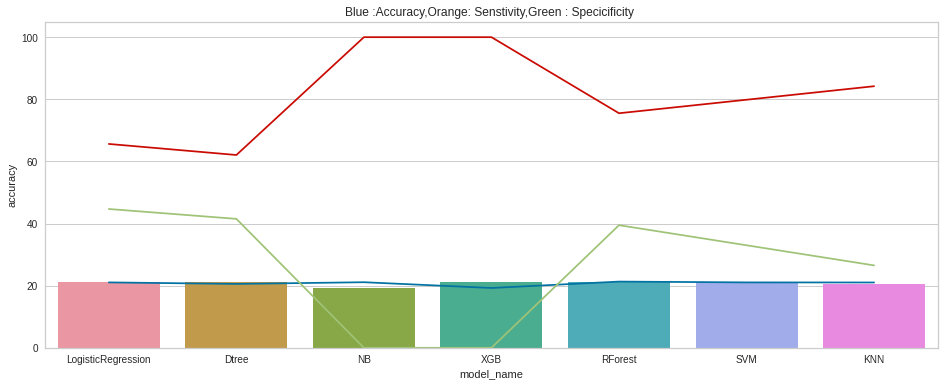

In [36]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

as you can see, almost all algo's give around 20 percent accuracy which is not great. So now lets add counts columns from liar liar

In [0]:
liar_clean2 = liar[['cosineSim','label','barely_true_counts', 'false_counts', 'half_true_counts','mostly_true_counts', 'pants_on_fire_counts']]

In [0]:
liar_clean2=liar_clean2.fillna(0)
X=liar_clean2.loc[:,liar_clean2.columns!='label']
Y=liar_clean2.loc[:,liar_clean2.columns=='label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[ 66  41 338  84   7   0]
 [ 52 113 404 104  15   0]
 [ 73  51 509  91   3   0]
 [ 51  36 347 211   2   0]
 [ 20  54 145  38  33   0]
 [ 35  20 392 116   2   0]]
Accuracy :  26.991022299449753
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.22      0.12      0.16       536
           1       0.36      0.16      0.23       688
           2       0.24      0.70      0.36       727
           3       0.33      0.33      0.33       647
           4       0.53      0.11      0.19       290
           5       0.00      0.00      0.00       565

    accuracy                           0.27      3453
   macro avg       0.28      0.24      0.21      3453
weighted avg       0.26      0.27      0.22      3453

********************************************************************************************

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: RForest
Confusion Matrix: 
[[200 101  83  84  19  49]
 [ 82 280  99 103  49  75]
 [ 82  94 294 169  15  73]
 [ 68  84 110 287  12  86]
 [ 32  64  39  21 119  15]
 [ 71  78 103 125  16 172]]
Accuracy :  39.15435852881552
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.37      0.37      0.37       536
           1       0.40      0.41      0.40       688
           2       0.40      0.40      0.40       727
           3       0.36      0.44      0.40       647
           4       0.52      0.41      0.46       290
           5       0.37      0.30      0.33       565

    accuracy                           0.39      3453
   macro avg       0.40      0.39      0.40      3453
weighted avg       0.39      0.39      0.39      3453



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************************************************************************************
Model: SVM
Confusion Matrix: 
[[198 126  98  79  16  19]
 [ 62 353 112 100  34  27]
 [ 59 124 356 133  18  37]
 [ 52  94 127 313  14  47]
 [ 37  70  37  16 124   6]
 [ 52  98 127 128  17 143]]
Accuracy :  43.06400231682595
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.43      0.37      0.40       536
           1       0.41      0.51      0.45       688
           2       0.42      0.49      0.45       727
           3       0.41      0.48      0.44       647
           4       0.56      0.43      0.48       290
           5       0.51      0.25      0.34       565

    accuracy                           0.43      3453
   macro avg       0.45      0.42      0.43      3453
weighted avg       0.44      0.43      0.43      3453



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: KNN
Confusion Matrix: 
[[281  80  81  49  22  23]
 [167 296  94  55  45  31]
 [209  99 292  74  22  31]
 [175  76 148 204  11  33]
 [ 60  52  43  14 115   6]
 [153  65 122  62  18 145]]
Accuracy :  38.6041123660585
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.27      0.52      0.36       536
           1       0.44      0.43      0.44       688
           2       0.37      0.40      0.39       727
           3       0.45      0.32      0.37       647
           4       0.49      0.40      0.44       290
           5       0.54      0.26      0.35       565

    accuracy                           0.39      3453
   macro avg       0.43      0.39      0.39      3453
weighted avg       0.42      0.39      0.39      3453



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

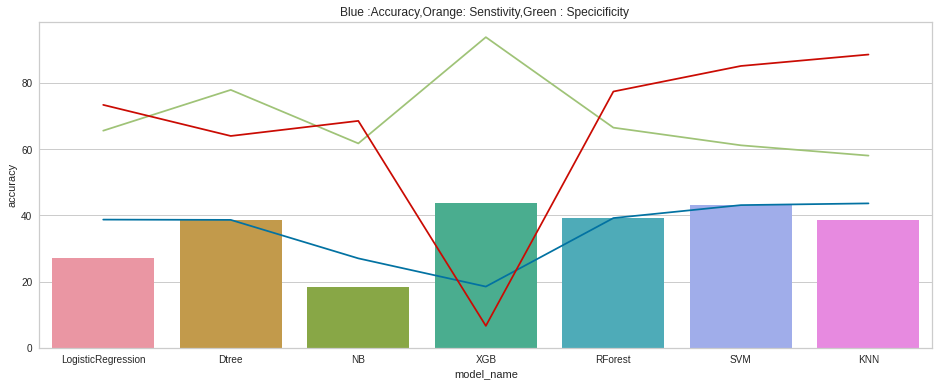

In [39]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

when we added the count columns, our accuracy bumped up more than twice and xgb along with svm fared best

#NER

Now lets use Named Entity Recognition and do feature engineering

In [0]:
import spacy
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")
def generate_ner(text):
    doc = nlp(text)
    return [str(chunk) for chunk in doc.noun_chunks] + [str(token) for token in doc if token.pos_ == "VERB"]

def generate_ner_verb(text):
    doc = nlp(text)
    return [str(token) for token in doc if token.pos_ == "VERB"]

def spacy_similarity(t1,t2):
    doc1 = nlp(t1)
    doc2 = nlp(t2)
    return doc1.similarity(doc2)

In [0]:
liar['noVeStatement'] = liar['finalStatement'].apply(lambda x: ' '.join(generate_ner(x)))

In [0]:
liar['noVeSubject'] = liar['subjectSynonyms'].apply(lambda x: ' '.join(generate_ner(x)))

In [0]:
liar['nerScore'] = liar.apply(lambda x: (spacy_similarity(x.noVeSubject,x.noVeStatement)),axis=1)

In [0]:
liar_clean3 = liar[['nerScore','cosineSim','label','barely_true_counts', 'false_counts', 'half_true_counts','mostly_true_counts', 'pants_on_fire_counts']]

In [0]:
liar_clean3=liar_clean3.fillna(0)
X=liar_clean3.loc[:,liar_clean3.columns!='label']
Y=liar_clean3.loc[:,liar_clean3.columns=='label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# Running models with NER scores combined

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[ 66  43 319 101   7   0]
 [ 52 159 348 110  19   0]
 [ 72  61 466 124   4   0]
 [ 48  61 248 289   1   0]
 [ 21  70 133  40  26   0]
 [ 32  39 337 155   2   0]]
Accuracy :  29.134086301766583
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.23      0.12      0.16       536
           1       0.37      0.23      0.28       688
           2       0.25      0.64      0.36       727
           3       0.35      0.45      0.39       647
           4       0.44      0.09      0.15       290
           5       0.00      0.00      0.00       565

    accuracy                           0.29      3453
   macro avg       0.27      0.26      0.22      3453
weighted avg       0.26      0.29      0.24      3453

********************************************************************************************

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: RForest
Confusion Matrix: 
[[184 120  84  71  27  50]
 [ 91 280 102 103  51  61]
 [ 89 106 290 140  30  72]
 [ 72  90 100 260  25 100]
 [ 33  55  44  30 108  20]
 [ 73  86  97 109  14 186]]
Accuracy :  37.88010425716768
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       536
           1       0.38      0.41      0.39       688
           2       0.40      0.40      0.40       727
           3       0.36      0.40      0.38       647
           4       0.42      0.37      0.40       290
           5       0.38      0.33      0.35       565

    accuracy                           0.38      3453
   macro avg       0.38      0.38      0.38      3453
weighted avg       0.38      0.38      0.38      3453



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************************************************************************************
Model: SVM
Confusion Matrix: 
[[201 119 106  76  16  18]
 [ 64 346 121  92  38  27]
 [ 59 121 371 124  16  36]
 [ 52  96 143 297  13  46]
 [ 38  66  37  18 125   6]
 [ 53  95 140 119  16 142]]
Accuracy :  42.919200695047785
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.43      0.38      0.40       536
           1       0.41      0.50      0.45       688
           2       0.40      0.51      0.45       727
           3       0.41      0.46      0.43       647
           4       0.56      0.43      0.49       290
           5       0.52      0.25      0.34       565

    accuracy                           0.43      3453
   macro avg       0.45      0.42      0.43      3453
weighted avg       0.44      0.43      0.42      3453



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: KNN
Confusion Matrix: 
[[243  99  82  72  17  23]
 [147 287 109  66  34  45]
 [155 107 300  91  17  57]
 [112 104 129 239   9  54]
 [ 50  68  38  23 101  10]
 [107  85 113  76  17 167]]
Accuracy :  38.719953663481036
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.30      0.45      0.36       536
           1       0.38      0.42      0.40       688
           2       0.39      0.41      0.40       727
           3       0.42      0.37      0.39       647
           4       0.52      0.35      0.42       290
           5       0.47      0.30      0.36       565

    accuracy                           0.39      3453
   macro avg       0.41      0.38      0.39      3453
weighted avg       0.40      0.39      0.39      3453



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

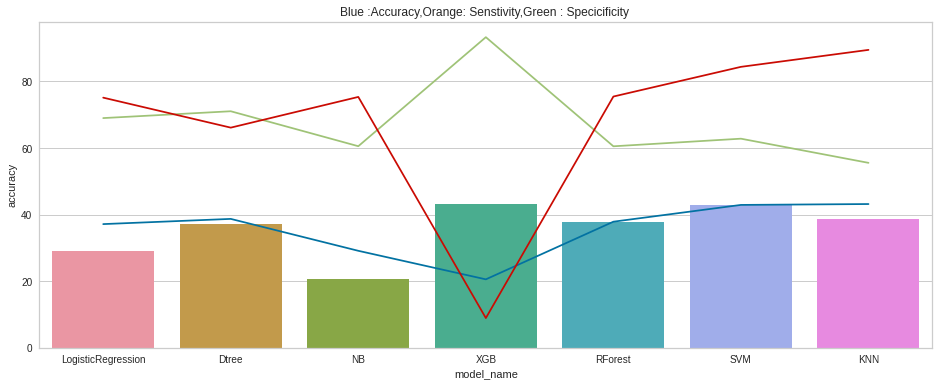

In [46]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

sfter our NER intro, there is a very slight bump in accuracy for xgb model. but apart from this, almost all models gave very similar accuracies compared to previous ones

In [0]:
# liar 

#sentiment analysis

now lets add sentiment analysis scores using our title and body

In [50]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

     |████████████████████████████████| 133kB 2.6MB/s 


In [0]:
liar['positiveScore']=liar['test_string'].apply(lambda x: sentiment_analyzer_scores(x)['pos'])
liar['negativeScore']=liar['test_string'].apply(lambda x: sentiment_analyzer_scores(x)['neg'])
liar['neutralScore']=liar['test_string'].apply(lambda x: sentiment_analyzer_scores(x)['neu'])

In [0]:
liar_clean4 = liar[['nerScore','cosineSim','label','barely_true_counts', 'false_counts', 'half_true_counts','mostly_true_counts', 'pants_on_fire_counts','positiveScore','negativeScore','neutralScore']]

In [0]:
liar_clean4=liar_clean4.fillna(0)
X=liar_clean4.loc[:,liar_clean4.columns!='label']
Y=liar_clean4.loc[:,liar_clean4.columns=='label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# running models with senti score combined

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[ 67  39 314 105  11   0]
 [ 53 142 363 105  25   0]
 [ 72  55 497  97   6   0]
 [ 50  49 233 310   5   0]
 [ 20  55 135  42  38   0]
 [ 33  32 359 139   2   0]]
Accuracy :  30.52418187083695
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.23      0.12      0.16       536
           1       0.38      0.21      0.27       688
           2       0.26      0.68      0.38       727
           3       0.39      0.48      0.43       647
           4       0.44      0.13      0.20       290
           5       0.00      0.00      0.00       565

    accuracy                           0.31      3453
   macro avg       0.28      0.27      0.24      3453
weighted avg       0.28      0.31      0.26      3453

*********************************************************************************************

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: RForest
Confusion Matrix: 
[[200  99  87  85  24  41]
 [ 95 284 113  78  51  67]
 [ 96 115 317 111  16  72]
 [ 77  95  98 268  20  89]
 [ 41  58  46  27 102  16]
 [ 62  78 119  96  17 193]]
Accuracy :  39.50188242108312
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.35      0.37      0.36       536
           1       0.39      0.41      0.40       688
           2       0.41      0.44      0.42       727
           3       0.40      0.41      0.41       647
           4       0.44      0.35      0.39       290
           5       0.40      0.34      0.37       565

    accuracy                           0.40      3453
   macro avg       0.40      0.39      0.39      3453
weighted avg       0.40      0.40      0.39      3453



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************************************************************************************
Model: SVM
Confusion Matrix: 
[[209 121  93  80  16  17]
 [ 77 346  98 107  34  26]
 [ 67 123 332 152  17  36]
 [ 53  96 112 327  13  46]
 [ 40  66  34  20 125   5]
 [ 56  97 116 139  15 142]]
Accuracy :  42.89024037069215
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.42      0.39      0.40       536
           1       0.41      0.50      0.45       688
           2       0.42      0.46      0.44       727
           3       0.40      0.51      0.44       647
           4       0.57      0.43      0.49       290
           5       0.52      0.25      0.34       565

    accuracy                           0.43      3453
   macro avg       0.46      0.42      0.43      3453
weighted avg       0.44      0.43      0.42      3453



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: KNN
Confusion Matrix: 
[[249  87  86  66  24  24]
 [137 297 105  75  37  37]
 [143 115 294 102  19  54]
 [120 103 107 244  15  58]
 [ 58  54  42  19 104  13]
 [ 97  98 109  79  14 168]]
Accuracy :  39.270199826238056
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.31      0.46      0.37       536
           1       0.39      0.43      0.41       688
           2       0.40      0.40      0.40       727
           3       0.42      0.38      0.40       647
           4       0.49      0.36      0.41       290
           5       0.47      0.30      0.37       565

    accuracy                           0.39      3453
   macro avg       0.41      0.39      0.39      3453
weighted avg       0.41      0.39      0.39      3453



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

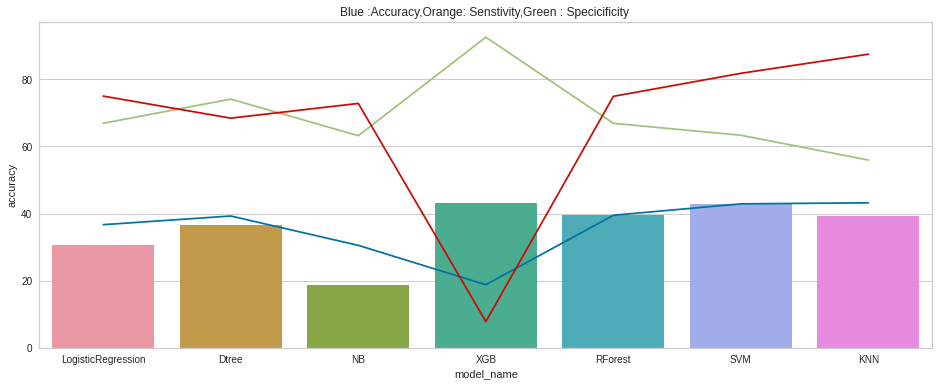

In [59]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

even though after applying the sentiment scores of both title and body, we only get a fraction of increase in average. Still i believe it has something to do with improvement

#downloading Kaggle News Dataset

In [0]:
# link = 'https://drive.google.com/open?id=1wMizWzlDLkm8pIFEVPeqqlP8m-sCalWm'
# fluff1, id1 = link.split('=')
# print (id) # Verify that you have everything after '='
# downloaded = drive.CreateFile({'id':id1}) 
# downloaded.GetContentFile('train.csv')

link = ' https://drive.google.com/open?id=1wMizWzlDLkm8pIFEVPeqqlP8m-sCalWm'
fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('fakeNews.csv')

In [67]:
link = 'https://drive.google.com/open?id=18z6S7CzSPgTT7Csj44jeT6M42B3xSek1'
fluff1, id1 = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id1}) 
downloaded.GetContentFile('test_fakeNews.csv')

1wMizWzlDLkm8pIFEVPeqqlP8m-sCalWm


In [0]:
trainFake = '/content/fakeNews.csv'
testFake = '/content/test_fakeNews.csv'

In [0]:
fakeTrain = pd.read_csv(trainFake)
fakeTest = pd.read_csv(testFake)

In [72]:
fakeTrain['label'].unique()

array([1, 0])

In [0]:
fake = pd.concat([fakeTrain,fakeTest])

In [74]:
fake.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0.0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1.0
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1.0
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1.0


In [0]:
fake = fake[['title','text','label']]

In [0]:
fake['finalHeaderBody'] = fake.apply(lambda row: remove_punctuations(row['text']), axis=1)

In [0]:
fake['finalHeaderBody'] = fake.apply(lambda row: tokenize(row['finalHeaderBody']), axis=1)

In [0]:
fake['finalHeaderBody'] = fake.apply(lambda row: lematize(row['finalHeaderBody']), axis=1)

In [0]:
fake['finalHeaderBody'] = fake.apply(lambda row: stem(row['finalHeaderBody']), axis=1)

lets clean the title

In [0]:
fake['finalTitle'] = fake.apply(lambda row: remove_punctuations(row['title']), axis=1)

fake['finalTitle'] = fake.apply(lambda row: tokenize(row['finalTitle']), axis=1)

# fake['finalHeaderBody'] = fake.apply(lambda row: remove_stopwords(row['finalHeaderBody']), axis=1)

fake['finalTitle'] = fake.apply(lambda row: lematize(row['finalTitle']), axis=1)

fake['finalTitle'] = fake.apply(lambda row: stem(row['finalTitle']), axis=1)

In [0]:
fake = fake[['finalTitle','finalHeaderBody','label']]

In [0]:
fake['test_string'] = fake['finalHeaderBody'] +'@@'+fake['finalTitle']

In [0]:
fake['cosineSim'] = fake['test_string'].apply(lambda x: cosine_sim(x))

In [85]:
fake.head()

,finalTitle,finalHeaderBody,label,test_string,cosineSim
0,hous dem aid we didn t even see comey s letter...,hous dem aid we didn t even see comey s letter...,1.0,hous dem aid we didn t even see comey s letter...,0.390770
1,flynn hillari clinton big woman on campu breit...,ever get the feel your life circl the roundabo...,0.0,ever get the feel your life circl the roundabo...,0.171162
2,whi the truth might get you fire,whi the truth might get you fire octob 29 2016...,1.0,whi the truth might get you fire octob 29 2016...,0.093800
3,15 civilian kill in singl u airstrik have been...,video 15 civilian kill in singl u airstrik hav...,1.0,video 15 civilian kill in singl u airstrik hav...,0.358106
4,iranian woman jail for fiction unpublish stori...,print an iranian woman ha been sentenc to six ...,1.0,print an iranian woman ha been sentenc to six ...,0.366995


In [0]:
fake_clean1 = fake[['cosineSim','label']]

In [0]:
fake_clean1=fake_clean1.fillna(0)
X=fake_clean1.loc[:,fake_clean1.columns!='label']
Y=fake_clean1.loc[:,fake_clean1.columns=='label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

#running models with cosine similarity in fake news dataset

In [88]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[4664    4]
 [3087   45]]
Accuracy :  60.37179487179487
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75      4668
         1.0       0.92      0.01      0.03      3132

    accuracy                           0.60      7800
   macro avg       0.76      0.51      0.39      7800
weighted avg       0.73      0.60      0.46      7800

****************************************************************************************************
Model: Dtree
Confusion Matrix: 
[[2949 1719]
 [1653 1479]]
Accuracy :  56.769230769230774
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.64      0.63      0.64      4668
         1.0       0.46      0.47      0.47      3132

    accuracy                           0.57      7800
   macro av

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBoostError: ignored

for some reason, xgb doesnt run but naive bayes has given 65 % accuracy which is again okayish in my view

In [0]:
li = liar[['label','cosineSim']]
fa = fake[['label','cosineSim']]

# Amalgamating both liar liar and fake news

In [0]:
amal = pd.concat([fa,li])

In [0]:
amal = amal.fillna(0)
X=amal.loc[:,amal.columns!='label']
Y=amal.loc[:,amal.columns=='label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# running models on amalgamated data with cosine similarity

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[5278    0    0    0    0    0]
 [3807    0    0    0    0    0]
 [ 715    0    0    0    0    0]
 [ 621    0    0    0    0    0]
 [ 284    0    0    0    0    0]
 [ 548    0    0    0    0    0]]
Accuracy :  46.90304807606861
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64      5278
         1.0       0.00      0.00      0.00      3807
         2.0       0.00      0.00      0.00       715
         3.0       0.00      0.00      0.00       621
         4.0       0.00      0.00      0.00       284
         5.0       0.00      0.00      0.00       548

    accuracy                           0.47     11253
   macro avg       0.08      0.17      0.11     11253
weighted avg       0.22      0.47      0.30     11253

*********************************************************

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.64      0.57      0.60      5278
         1.0       0.34      0.56      0.42      3807
         2.0       0.12      0.02      0.03       715
         3.0       0.11      0.02      0.04       621
         4.0       0.03      0.00      0.01       284
         5.0       0.09      0.01      0.02       548

    accuracy                           0.46     11253
   macro avg       0.22      0.20      0.19     11253
weighted avg       0.43      0.46      0.43     11253

****************************************************************************************************
Model: NB
Confusion Matrix: 
[[4365  313  600    0    0    0]
 [2399  466  942    0    0    0]
 [ 108    0  607    0    0    0]
 [  83    0  538    0    0    0]
 [  38    0  246    0    0    0]
 [  82    0  466    0    0    0]]
Accuracy :  48.32489114014041
Classificarion Report : 
              precision    recall  f1-score   su

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************************************************************************************
Model: XGB
Confusion Matrix: 
[[4325  953    0    0    0    0]
 [2348 1459    0    0    0    0]
 [  89  626    0    0    0    0]
 [  62  559    0    0    0    0]
 [  28  256    0    0    0    0]
 [  71  477    0    0    0    0]]
Accuracy :  51.39962676619568
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.62      0.82      0.71      5278
         1.0       0.34      0.38      0.36      3807
         2.0       0.00      0.00      0.00       715
         3.0       0.00      0.00      0.00       621
         4.0       0.00      0.00      0.00       284
         5.0       0.00      0.00      0.00       548

    accuracy                           0.51     11253
   macro avg       0.16      0.20      0.18     11253
weighted avg       0.41      0.51      0.45     11253



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: RForest
Confusion Matrix: 
[[2970 2181   42   36   11   38]
 [1569 2132   32   42   10   22]
 [  23  644   15   21    2   10]
 [  21  551   20   14    4   11]
 [   7  259    4    8    1    5]
 [  20  486   12   18    2   10]]
Accuracy :  45.694481471607574
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.64      0.56      0.60      5278
         1.0       0.34      0.56      0.42      3807
         2.0       0.12      0.02      0.04       715
         3.0       0.10      0.02      0.04       621
         4.0       0.03      0.00      0.01       284
         5.0       0.10      0.02      0.03       548

    accuracy                           0.46     11253
   macro avg       0.22      0.20      0.19     11253
weighted avg       0.44      0.46      0.43     11253



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************************************************************************************
Model: SVM
Confusion Matrix: 
[[4328  950    0    0    0    0]
 [2312 1495    0    0    0    0]
 [  71  644    0    0    0    0]
 [  43  578    0    0    0    0]
 [  23  261    0    0    0    0]
 [  59  489    0    0    0    0]]
Accuracy :  51.746201013063185
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.63      0.82      0.71      5278
         1.0       0.34      0.39      0.36      3807
         2.0       0.00      0.00      0.00       715
         3.0       0.00      0.00      0.00       621
         4.0       0.00      0.00      0.00       284
         5.0       0.00      0.00      0.00       548

    accuracy                           0.52     11253
   macro avg       0.16      0.20      0.18     11253
weighted avg       0.41      0.52      0.46     11253



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: KNN
Confusion Matrix: 
[[3459 1203  576   23    5   12]
 [1865 1008  891   27    5   11]
 [  55   34  607   16    1    2]
 [  34   29  542    7    4    5]
 [  16   14  245    6    1    2]
 [  39   28  466   10    1    4]]
Accuracy :  45.19683639918244
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.63      0.66      0.64      5278
         1.0       0.44      0.26      0.33      3807
         2.0       0.18      0.85      0.30       715
         3.0       0.08      0.01      0.02       621
         4.0       0.06      0.00      0.01       284
         5.0       0.11      0.01      0.01       548

    accuracy                           0.45     11253
   macro avg       0.25      0.30      0.22     11253
weighted avg       0.47      0.45      0.43     11253



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

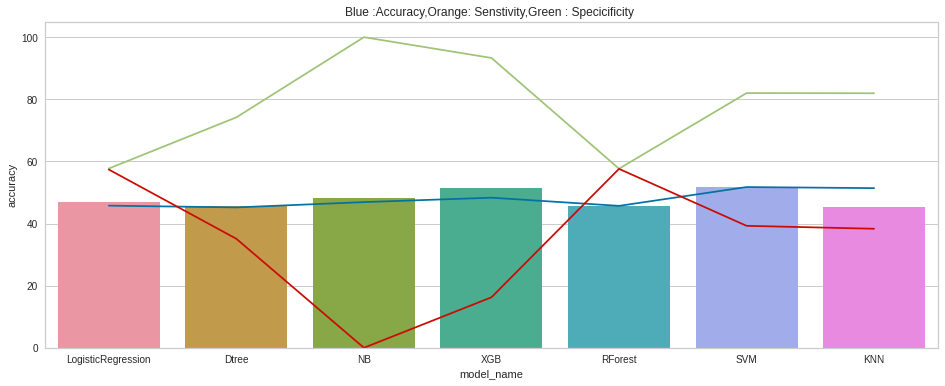

In [94]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

The amalgamted dataset best performed by svm and xgb with accuracy of slightly more than 50 for 6 class classification

In [0]:
fake['positiveScore']=fake['finalTitle'].apply(lambda x: sentiment_analyzer_scores(x)['pos'])
fake['negativeScore']=fake['finalTitle'].apply(lambda x: sentiment_analyzer_scores(x)['neg'])
fake['neutralScore']=fake['finalTitle'].apply(lambda x: sentiment_analyzer_scores(x)['neu'])

In [0]:
f_c = fake[['cosineSim','label','positiveScore','negativeScore','neutralScore']]
l_c = liar[['cosineSim','label','positiveScore','negativeScore','neutralScore']]

In [0]:
amal1 = pd.concat([f_c,l_c])

In [0]:
amal1 = amal1.fillna(0)
X=amal1.loc[:,amal1.columns!='label']
Y=amal1.loc[:,amal1.columns=='label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# running models on amalgamated data with sentiment scores combined

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[5272    0    6    0    0    0]
 [3794    2   11    0    0    0]
 [ 709    0    6    0    0    0]
 [ 616    0    5    0    0    0]
 [ 280    0    4    0    0    0]
 [ 537    0   11    0    0    0]]
Accuracy :  46.9208211143695
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64      5278
         1.0       1.00      0.00      0.00      3807
         2.0       0.14      0.01      0.02       715
         3.0       0.00      0.00      0.00       621
         4.0       0.00      0.00      0.00       284
         5.0       0.00      0.00      0.00       548

    accuracy                           0.47     11253
   macro avg       0.27      0.17      0.11     11253
weighted avg       0.57      0.47      0.30     11253

**********************************************************

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

****************************************************************************************************
Model: XGB
Confusion Matrix: 
[[4277  819  160   22    0    0]
 [2264 1359  165   19    0    0]
 [  90  413  191   21    0    0]
 [  64  388  151   18    0    0]
 [  32  177   67    8    0    0]
 [  73  344  117   14    0    0]]
Accuracy :  51.94170443437306
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.63      0.81      0.71      5278
         1.0       0.39      0.36      0.37      3807
         2.0       0.22      0.27      0.24       715
         3.0       0.18      0.03      0.05       621
         4.0       0.00      0.00      0.00       284
         5.0       0.00      0.00      0.00       548

    accuracy                           0.52     11253
   macro avg       0.24      0.24      0.23     11253
weighted avg       0.45      0.52      0.48     11253



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: RForest
Confusion Matrix: 
[[3178 1829  103   85   25   58]
 [1710 1805  116   79   24   73]
 [ 115  337  115   71   20   57]
 [ 103  304   91   56   21   46]
 [  46  136   47   31    8   16]
 [  77  289   59   57   25   41]]
Accuracy :  46.236559139784944
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.61      0.60      0.60      5278
         1.0       0.38      0.47      0.42      3807
         2.0       0.22      0.16      0.18       715
         3.0       0.15      0.09      0.11       621
         4.0       0.07      0.03      0.04       284
         5.0       0.14      0.07      0.10       548

    accuracy                           0.46     11253
   macro avg       0.26      0.24      0.24     11253
weighted avg       0.45      0.46      0.45     11253



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************************************************************************************
Model: SVM
Confusion Matrix: 
[[5224   54    0    0    0    0]
 [3657  150    0    0    0    0]
 [ 712    3    0    0    0    0]
 [ 618    3    0    0    0    0]
 [ 284    0    0    0    0    0]
 [ 542    6    0    0    0    0]]
Accuracy :  47.756153914511685
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.47      0.99      0.64      5278
         1.0       0.69      0.04      0.07      3807
         2.0       0.00      0.00      0.00       715
         3.0       0.00      0.00      0.00       621
         4.0       0.00      0.00      0.00       284
         5.0       0.00      0.00      0.00       548

    accuracy                           0.48     11253
   macro avg       0.19      0.17      0.12     11253
weighted avg       0.46      0.48      0.33     11253



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: KNN
Confusion Matrix: 
[[3600 1238   77  310    6   47]
 [1941 1171   92  543   13   47]
 [ 181  123   86  277    5   43]
 [ 145   95   71  270    7   33]
 [  76   35   42  112    2   17]
 [ 130   83   53  243    6   33]]
Accuracy :  45.872211854616545
Classificarion Report : 
              precision    recall  f1-score   support

         0.0       0.59      0.68      0.63      5278
         1.0       0.43      0.31      0.36      3807
         2.0       0.20      0.12      0.15       715
         3.0       0.15      0.43      0.23       621
         4.0       0.05      0.01      0.01       284
         5.0       0.15      0.06      0.09       548

    accuracy                           0.46     11253
   macro avg       0.26      0.27      0.24     11253
weighted avg       0.45      0.46      0.45     11253



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

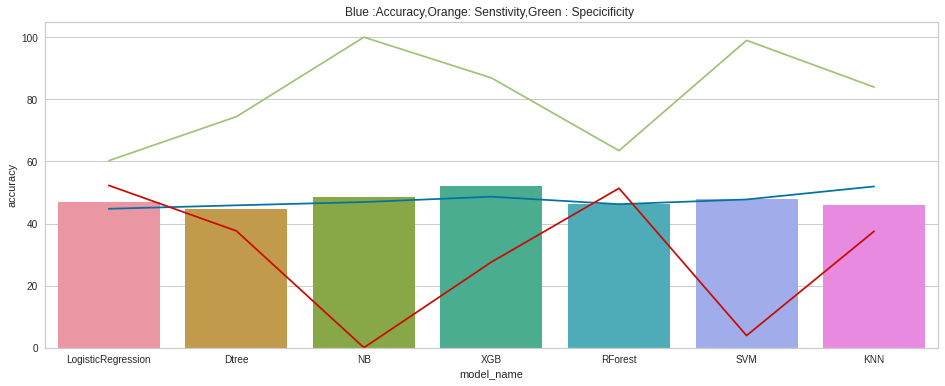

In [100]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

xgb performed best with accuracy of 52% which is good for a 6 class classification

In [101]:
fake.head()

,finalTitle,finalHeaderBody,label,test_string,cosineSim,positiveScore,negativeScore,neutralScore
0,hous dem aid we didn t even see comey s letter...,hous dem aid we didn t even see comey s letter...,1.0,hous dem aid we didn t even see comey s letter...,0.390770,0.000,0.000,1.000
1,flynn hillari clinton big woman on campu breit...,ever get the feel your life circl the roundabo...,0.0,ever get the feel your life circl the roundabo...,0.171162,0.000,0.000,1.000
2,whi the truth might get you fire,whi the truth might get you fire octob 29 2016...,1.0,whi the truth might get you fire octob 29 2016...,0.093800,0.237,0.247,0.515
3,15 civilian kill in singl u airstrik have been...,video 15 civilian kill in singl u airstrik hav...,1.0,video 15 civilian kill in singl u airstrik hav...,0.358106,0.000,0.343,0.657
4,iranian woman jail for fiction unpublish stori...,print an iranian woman ha been sentenc to six ...,1.0,print an iranian woman ha been sentenc to six ...,0.366995,0.000,0.231,0.769


In [102]:
fake

,finalTitle,finalHeaderBody,label,test_string,cosineSim,positiveScore,negativeScore,neutralScore
0,hous dem aid we didn t even see comey s letter...,hous dem aid we didn t even see comey s letter...,1.0,hous dem aid we didn t even see comey s letter...,0.390770,0.000,0.000,1.000
1,flynn hillari clinton big woman on campu breit...,ever get the feel your life circl the roundabo...,0.0,ever get the feel your life circl the roundabo...,0.171162,0.000,0.000,1.000
2,whi the truth might get you fire,whi the truth might get you fire octob 29 2016...,1.0,whi the truth might get you fire octob 29 2016...,0.093800,0.237,0.247,0.515
3,15 civilian kill in singl u airstrik have been...,video 15 civilian kill in singl u airstrik hav...,1.0,video 15 civilian kill in singl u airstrik hav...,0.358106,0.000,0.343,0.657
4,iranian woman jail for fiction unpublish stori...,print an iranian woman ha been sentenc to six ...,1.0,print an iranian woman ha been sentenc to six ...,0.366995,0.000,0.231,0.769
...,...,...,...,...,...,...,...,...
5195,the bangladeshi traffic jam that never end the...,of all the dysfunct that plagu the world s meg...,NaN,of all the dysfunct that plagu the world s meg...,0.168387,0.000,0.000,1.000
5196,john kasich sign one abort bill in ohio but ve...,washington gov john kasich of ohio on tuesday ...,NaN,washington gov john kasich of ohio on tuesday ...,0.256108,0.000,0.184,0.816
5197,california today what exactli is in your sushi...,good morn want to get california today by emai...,NaN,good morn want to get california today by emai...,0.221154,0.000,0.000,1.000
5198,300 u marin to be deploy to russian border in ...,previou next 300 u marin to be deploy to russi...,NaN,previou next 300 u marin to be deploy to russi...,0.270868,0.000,0.000,1.000


#adding political party column in liarliar and checking accuracy

In [0]:
party=LabelEncoder()
party.fit(liar['party affiliation'].astype(str))
liar['party affiliation']=party.fit_transform(liar['party affiliation'].astype(str))

In [0]:
ll = liar[['party affiliation','nerScore','cosineSim','label','barely_true_counts', 'false_counts', 'half_true_counts','mostly_true_counts', 'pants_on_fire_counts','positiveScore','negativeScore','neutralScore']]

In [0]:
ll = ll.fillna(0)
X=ll.loc[:,ll.columns!='label']
Y=ll.loc[:,ll.columns=='label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

****************************************************************************************************
Model: LogisticRegression
Confusion Matrix: 
[[ 62 139 225 100  10   0]
 [ 49 280 192 144  23   0]
 [ 69 136 401 115   6   0]
 [ 47 169 127 301   3   0]
 [ 19 113  83  44  31   0]
 [ 32 138 222 170   3   0]]
Accuracy :  31.132348682305246
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.22      0.12      0.15       536
           1       0.29      0.41      0.34       688
           2       0.32      0.55      0.41       727
           3       0.34      0.47      0.40       647
           4       0.41      0.11      0.17       290
           5       0.00      0.00      0.00       565

    accuracy                           0.31      3453
   macro avg       0.26      0.27      0.24      3453
weighted avg       0.26      0.31      0.26      3453

********************************************************************************************

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: RForest
Confusion Matrix: 
[[199  95  96  92  23  31]
 [ 87 291 103  84  58  65]
 [ 94 112 309 114  19  79]
 [ 84  97 108 265  16  77]
 [ 46  53  48  29  99  15]
 [ 64  79 113 112  15 182]]
Accuracy :  38.9516362583261
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.35      0.37      0.36       536
           1       0.40      0.42      0.41       688
           2       0.40      0.43      0.41       727
           3       0.38      0.41      0.39       647
           4       0.43      0.34      0.38       290
           5       0.41      0.32      0.36       565

    accuracy                           0.39      3453
   macro avg       0.39      0.38      0.39      3453
weighted avg       0.39      0.39      0.39      3453



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


****************************************************************************************************
Model: SVM
Confusion Matrix: 
[[224 113  80  85  15  19]
 [ 84 329  95 102  49  29]
 [ 79 121 312 159  17  39]
 [ 58  89  98 343  11  48]
 [ 33  67  36  24 123   7]
 [ 62  93 107 141  13 149]]
Accuracy :  42.86128004633652
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.41      0.42      0.42       536
           1       0.41      0.48      0.44       688
           2       0.43      0.43      0.43       727
           3       0.40      0.53      0.46       647
           4       0.54      0.42      0.47       290
           5       0.51      0.26      0.35       565

    accuracy                           0.43      3453
   macro avg       0.45      0.42      0.43      3453
weighted avg       0.44      0.43      0.42      3453



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


****************************************************************************************************
Model: KNN
Confusion Matrix: 
[[233  95  89  68  24  27]
 [133 287 107  83  40  38]
 [141 117 287 100  23  59]
 [118 113 113 233  15  55]
 [ 51  56  47  23 100  13]
 [ 95  96 105  90  14 165]]
Accuracy :  37.79322328410078
Classificarion Report : 
              precision    recall  f1-score   support

           0       0.30      0.43      0.36       536
           1       0.38      0.42      0.40       688
           2       0.38      0.39      0.39       727
           3       0.39      0.36      0.37       647
           4       0.46      0.34      0.40       290
           5       0.46      0.29      0.36       565

    accuracy                           0.38      3453
   macro avg       0.40      0.37      0.38      3453
weighted avg       0.39      0.38      0.38      3453



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

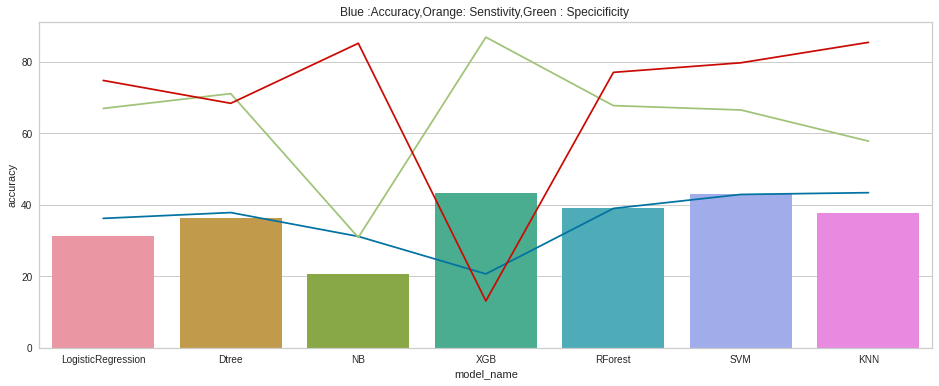

In [106]:
fitModelsAndPredict(models_dict,X_train,y_train,X_test,y_test)

again with political factor added, we get very slight increase in the accuracy by some fraction. 

#bert on Liar Liar dataset

performing bert on liar liar dataset

In [108]:
!pip install bert-for-tf2

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

In [0]:
#Loding pretrained bert layer
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=False)


In [0]:
# Loading tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocab_file, do_lower_case)

In [0]:
# function to encode the text into tokens, masks, and segment flags
import numpy as np
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
MAX_LEN = 64

# encode train set 
train_input = bert_encode(liar.finalStatement.values, tokenizer, max_len=MAX_LEN)
# encode  test set 
# test_input = bert_encode(test_df.text.values, tokenizer, max_len= MAX_LEN )
train_labels = liar.subjectSynonyms.values

In [126]:
train_input

(array([[  101,  2360,  5754, ...,     0,     0,     0],
        [  101, 11703,  4115, ...,     0,     0,     0],
        [  101,  2940,  8486, ...,     0,     0,     0],
        ...,
        [  101,  4656,  2072, ...,     0,     0,     0],
        [  101,  2360, 19044, ...,     0,     0,     0],
        [  101,  2360,  3099, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [0]:
# first define input for token, mask and segment id  
from tensorflow.keras.layers import  Input
input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="segment_ids")

#  output  
from tensorflow.keras.layers import Dense
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])  
clf_output = sequence_output[:, 0, :]
out = Dense(1, activation='sigmoid')(clf_output)   

# intilize model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# train
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=2,
    batch_size=32
)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

bert model takes soo long to train

In [0]:
test_pred = model.predict('Says the Annies List political group supports')
preds = test_pred.round().astype(int)
preds